Loading trajectory from  ../data/P001/pose_left.txt
--- Added keyframe 0 (seq id: 0) ---
current point number: 0
extracting more features: 500
add 496 measurements to backend
add prior factor for frame  0
--- Added keyframe 1 (seq id: 2) ---
current point number: 342
extracting more features: 158
add 494 measurements to backend
--- Added keyframe 2 (seq id: 4) ---
current point number: 436
extracting more features: 64
add 496 measurements to backend
--- Added keyframe 3 (seq id: 6) ---
current point number: 399
extracting more features: 101
add 414 measurements to backend
--- Added keyframe 4 (seq id: 8) ---
current point number: 376
extracting more features: 124
add 412 measurements to backend
--- Added keyframe 5 (seq id: 10) ---
current point number: 424
extracting more features: 76
add 405 measurements to backend
--- Added keyframe 6 (seq id: 12) ---
current point number: 439
extracting more features: 61
add 381 measurements to backend
--- Added keyframe 7 (seq id: 14) ---
current 

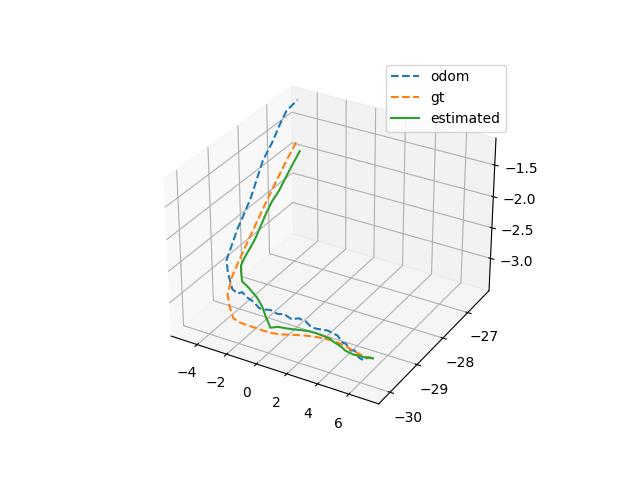

In [69]:

# frontend
import numpy as np
from spatialmath import *
import cv2
import os
%matplotlib widget
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import cm

# backend
import gtsam
from gtsam.symbol_shorthand import L, X

# our slam implementation
from minslam.data_loader import TartanAirLoader
from minslam.frontend import Frontend
from minslam.params import Params
from minslam.backend import Backend
from minslam.camera import PinholeCamera


def run_frontend_once(frontend):
    pose = dataset.read_current_odometry()
    while not frontend.keyframe_selection(pose):
        if not dataset.load_next_frame():
            break
        pose = dataset.read_current_odometry()
    color, depth = dataset.read_current_rgbd()
    frontend.add_keyframe(pose, color, depth)
    print(f'--- Added keyframe {frontend.frame_id} (seq id: {dataset.curr_index}) ---')
    if frontend.frame_id > 0:
        frontend.match_features()
        frontend.eliminate_outliers()
    more_points_n = params['frontend']['feature']['number']-len(frontend.curr_frame.points)
    print('current point number:', len(frontend.curr_frame.points))
    if more_points_n>0:
        print('extracting more features:', more_points_n)
        frontend.extract_features(more_points_n, append_mode=True)
    frontend.assign_global_id()
    # frontend.plot_matches(with_global_id=True)
    return frontend.curr_frame

dataset_folder = '../data/P001/'
traj_filename = 'pose_left.txt'
traj_path = os.path.join(dataset_folder, traj_filename)
print('Loading trajectory from ', traj_path)

# load a trajectory
dataset = TartanAirLoader(dataset_folder)
gt_poses = dataset._load_traj('tum', traj_filename, add_timestamps=True)
odom_poses = dataset.add_noise(gt_poses, [1e-4, 3e-4], [1e-3, 1e-3], seed=100)

# set the gt as odom for testing
dataset.set_ground_truth(gt_poses)
dataset.set_odometry(odom_poses)

params = Params('../params/tartanair.yaml')
frontend = Frontend(params)
backend = Backend(params)
dataset.set_curr_index(0)
n_keyframes = 40

gt_traj = np.zeros((n_keyframes, 3))
odom_traj = np.zeros((n_keyframes, 3))

for i in range(n_keyframes):
    frontend_frame = run_frontend_once(frontend)
    gt_traj[i] = dataset.read_current_ground_truth().t
    odom_traj[i] = dataset.read_current_odometry().t
    measurements = []
    frame_id = frontend_frame.frame_id
    count = 0
    for landmark in frontend_frame.landmarks:
        global_id = landmark.global_id
        measurement = landmark.measurements[frame_id] # u, v, depth
        if not landmark.is_outlier_gt(frontend, 0.5) and measurement[2]<50:
            count += 1
            measurements.append((global_id, *measurement))
    print(f'add {count} measurements to backend')
    backend.add_keyframe(frame_id, frontend_frame.odom_pose, measurements)
backend.optimize(optimizer='LM')
backend_estimate = backend.current_estimate
estimated_traj = gtsam.utilities.extractPose3(backend_estimate)[:, -3:]

plt.clf()
ax = plt.figure().add_subplot(projection='3d')
ax.plot(odom_traj[:n_keyframes,0],odom_traj[:n_keyframes,1],odom_traj[:n_keyframes,2], '--', label='odom')
ax.plot(gt_traj[:n_keyframes,0],gt_traj[:n_keyframes,1],gt_traj[:n_keyframes,2], '--', label='gt')
ax.plot(estimated_traj[:n_keyframes,0],estimated_traj[:n_keyframes,1], estimated_traj[:n_keyframes,2], label='estimated')
ax.legend()

# Create cubic bounding box to simulate equal aspect ratio
# ref: https://stackoverflow.com/a/13701747
# X,Y,Z = estimated_traj[:,0], estimated_traj[:,1], estimated_traj[:,2]
# max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
# Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
# Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
# Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# for xb, yb, zb in zip(Xb, Yb, Zb):
#    ax.plot([xb], [yb], [zb], 'w')

In [15]:
backend.graph.error(backend.initial_estimate)
for global_id, landmark in frontend.landmarks.items():
    if global_id not in backend.factors:
        continue
    factor = backend.factors[global_id]
    if len(factor.measurements)>1:
        print('========')
        print('global_id=', global_id)
        for frame_id, measurement in factor.measurements.items():
            measurement = factor.measurements[frame_id]
            odom_pose = frontend.frames[frame_id].odom_pose
            point_xyz = backend.camera.back_project(*measurement, odom_pose)
            print('----')
            print('frame_id=', frame_id)
            print('measurement=', measurement)
            print('point_xyz=', point_xyz)
        print('gtsam=', factor.smart_factor)
        print()

global_id= 2
----
frame_id= 0
measurement= [233.50115966796875, 470.0142517089844, 6.3671875]
point_xyz= [[ 3.63026895]
 [-3.21066997]
 [ 0.6809116 ]]
----
frame_id= 1
measurement= [215.86072, 465.746, 6.1914062]
point_xyz= [[ 3.62940892]
 [-3.20494571]
 [ 0.68091767]]
gtsam= SmartProjectionPoseFactor, z = 
 SmartProjectionFactor
linearizationMode: 0
triangulationParameters:
rankTolerance = 1
enableEPI = 0
landmarkDistanceThreshold = -1
dynamicOutlierRejectionThreshold = -1
noise model

result:
point =  3.61221
-3.25528
0.664665

SmartFactorBase, z = 
measurement 0, px = 
233.501
470.014
noise model = unit (2) 
measurement 1, px = 
215.861
465.746
noise model = unit (2) 
body_P_sensor_:
 R: [
	0, 0, 1;
	1, 0, 0;
	0, 1, 0
]
t: 0 0 0
  keys = { x0 x1 }


global_id= 14
----
frame_id= 0
measurement= [563.5274047851562, 393.81146240234375, 7.203125]
point_xyz= [[-3.6022752 ]
 [-2.56635895]
 [ 1.72829602]]
----
frame_id= 1
measurement= [540.0333, 378.22522, 7.4414062]
point_xyz= [[-3.5996110

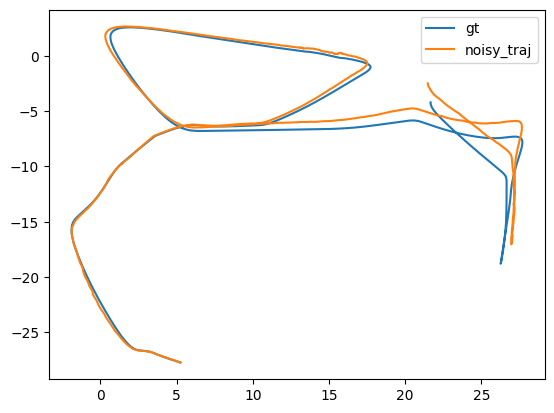

In [14]:
odom_poses = dataset.add_noise(gt_traj, [2e-4, 2e-4], [1e-3, 1e-3], seed=100)
gt_poses = np.array([x.t for x in gt_traj])
noisy_traj_poses = np.array([x.t for x in odom_poses])
plt.plot(gt_poses[:,0], gt_poses[:,1], label='gt')
plt.plot(noisy_traj_poses[:,0], noisy_traj_poses[:,1], label='noisy_traj')
plt.legend()

In [6]:
global_id =10
landmark = frontend.landmarks[global_id]
for frame_id in landmark.observed_frames:
    print(landmark.back_project(frontend, frame_id))
print(backend.current_estimate.atPoint3(L(global_id)))

[  7.21643389 -26.48760006  -2.70183477]
[  7.21643389 -26.48760006  -2.70183477]


In [7]:
print(backend.initial_estimate.atPoint3(X(0)))


RuntimeError: Attempting to retrieve value with key "x0", type stored in Values is gtsam::GenericValue<gtsam::Pose3> but requested type was Eigen::Matrix<double, -1, 1, 0, -1, 1>

In [7]:
estimated_traj

array([], shape=(0, 3), dtype=float64)